In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import keras
from keras_unet.models import custom_unet

2023-02-01 13:31:55.586234: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
#DATAPATH = '/Users/jiehyun/Jenna/UMassBoston/Research/Nathan_Arnett_Calcification/'
DATAPATH = '/raid/mpsych/CACTAS/DATA/Nathan Arnett Calcification'
images_file = os.path.join(DATAPATH, 'images.npy')
labels_file = os.path.join(DATAPATH, 'labels.npy')


In [4]:
images = np.load(images_file)
labels = np.load(labels_file)

In [5]:
# full dataset does not have the last channel
images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
labels = labels.reshape(labels.shape[0],labels.shape[1],labels.shape[2],1)

In [6]:
p = np.random.permutation(len(images))

In [7]:
images = images[p]
labels = labels[p]

In [8]:
images = images.astype(np.float64)
labels = labels.astype(np.float64)

In [9]:
for i in range(images.shape[0]):
    
    images[i] = (images[i] - images[i].min()) / (images[i].max() - images[i].min()) # normalize individually
    

In [10]:
images.shape

(503, 512, 512, 1)

In [11]:
labels.shape

(503, 512, 512, 1)

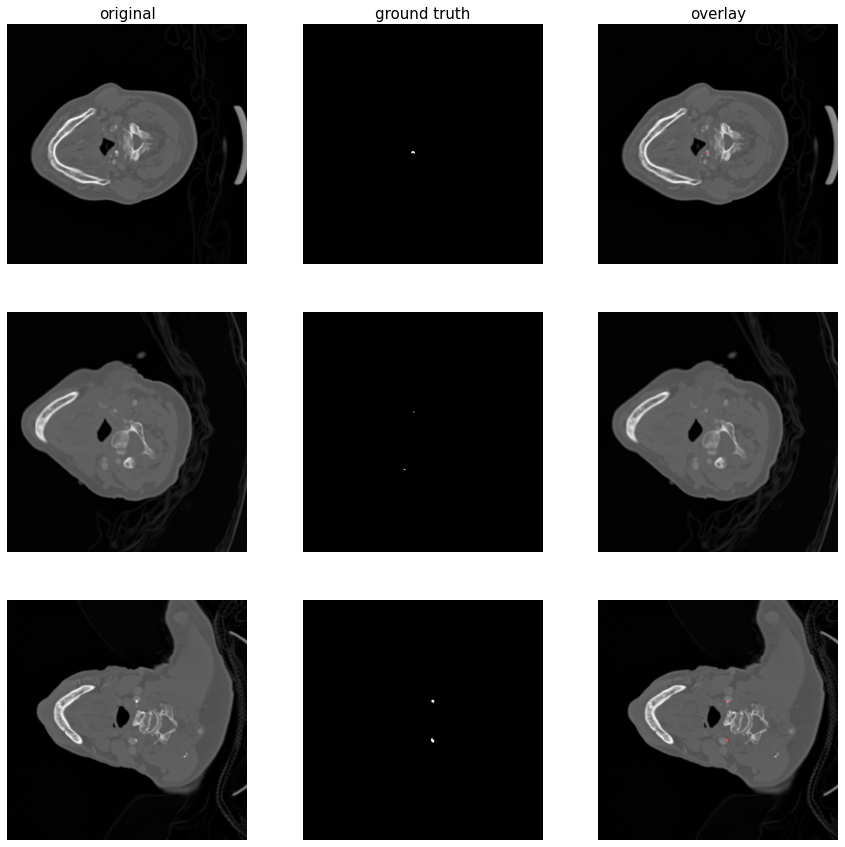

In [12]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=images, mask_imgs=labels, nm_img_to_plot=3, figsize=5)

In [13]:
X_train = images[0:300]
y_train = labels[0:300]
X_val = images[300:400]
y_val = labels[300:400]
X_test = images[400:]
y_test = labels[400:]

In [14]:
from keras_unet_collection import models, losses
import torch

model = models.swin_unet_2d((512, 512, 1), filter_num_begin=64,
                               n_labels=1, depth=4, stack_num_down=4, stack_num_up=4,
                               patch_size=(4, 4), num_heads=[4, 8, 16, 16],
                               window_size=[4, 4, 4, 4], num_mlp=512, 
                               output_activation='Sigmoid', shift_window=True, name='swin_unet')

#Softmax

2023-02-01 13:32:15.780536: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-02-01 13:32:15.864122: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-02-01 13:32:15.864167: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-02-01 13:32:15.864202: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 13:32:15.864218: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 13:32:15.871221: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [15]:
model.summary()

Model: "swin_unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
patch_extract (patch_extract)   (None, 16384, 16)    0           input_1[0][0]                    
__________________________________________________________________________________________________
patch_embedding (patch_embeddin (None, 16384, 64)    1049664     patch_extract[0][0]              
__________________________________________________________________________________________________
swin_transformer_block (SwinTra (None, 16384, 64)    83460       patch_embedding[0][0]            
____________________________________________________________________________________

In [16]:
from tensorflow.keras import optimizers
#from tensorflow.keras.optimizers import Adam
from keras_unet.metrics import iou, iou_thresholded, dice_coef
from keras_unet_collection import losses
#from keras_unet.losses import jaccard_distance

In [17]:
model.compile(loss='binary_crossentropy',
              #loss=jaccard_distance,
              optimizer=optimizers.Adam(lr=1e-3),
              #optimizer = 'Adam',
              metrics=['accuracy', dice_coef, iou, iou_thresholded])

/home/jiehyun.kim001/miniconda3/envs/O/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [18]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=100,
                    validation_data=(X_val, y_val))

2023-02-01 13:32:28.851295: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-02-01 13:32:28.873176: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245645000 Hz


Epoch 1/100


2023-02-01 13:32:53.564929: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-02-01 13:32:54.710285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-02-01 13:32:54.710684: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-01 13:32:54.848983: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-02-01 13:32:55.041017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500
2023-02-01 13:32:55.782729: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2023-02-01 13:32:55.782755: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2023-02-01 13:32:55.78313

19/19 [==============================] - 46s 1s/step - loss: 0.0946 - accuracy: 0.9614 - dice_coef: 8.5837e-04 - iou: 8.1149e-04 - iou_thresholded: 8.9232e-04 - val_loss: 0.0065 - val_accuracy: 0.9998 - val_dice_coef: 0.0014 - val_iou: 0.0014 - val_iou_thresholded: 0.0014
Epoch 2/100
19/19 [==============================] - 14s 735ms/step - loss: 0.0057 - accuracy: 0.9998 - dice_coef: 9.1858e-04 - iou: 7.9535e-04 - iou_thresholded: 0.0011 - val_loss: 0.0036 - val_accuracy: 0.9998 - val_dice_coef: 0.0014 - val_iou: 0.0011 - val_iou_thresholded: 0.0014
Epoch 3/100
19/19 [==============================] - 14s 739ms/step - loss: 0.0032 - accuracy: 0.9998 - dice_coef: 0.0013 - iou: 9.5607e-04 - iou_thresholded: 0.0011 - val_loss: 0.0032 - val_accuracy: 0.9998 - val_dice_coef: 0.0014 - val_iou: 0.0014 - val_iou_thresholded: 0.0014
Epoch 4/100
19/19 [==============================] - 14s 739ms/step - loss: 0.0076 - accuracy: 0.9995 - dice_coef: 0.0011 - iou: 0.0010 - iou_thresholded: 0.0012 -

19/19 [==============================] - 14s 750ms/step - loss: 0.0013 - accuracy: 0.9998 - dice_coef: 0.0618 - iou: 0.0326 - iou_thresholded: 0.0291 - val_loss: 0.0011 - val_accuracy: 0.9998 - val_dice_coef: 0.0500 - val_iou: 0.0262 - val_iou_thresholded: 0.0071
Epoch 31/100
19/19 [==============================] - 14s 733ms/step - loss: 0.0010 - accuracy: 0.9998 - dice_coef: 0.1245 - iou: 0.0671 - iou_thresholded: 0.0585 - val_loss: 9.7019e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.1003 - val_iou: 0.0533 - val_iou_thresholded: 0.0288
Epoch 32/100
19/19 [==============================] - 14s 735ms/step - loss: 8.7021e-04 - accuracy: 0.9998 - dice_coef: 0.1847 - iou: 0.1027 - iou_thresholded: 0.1123 - val_loss: 8.8694e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.1228 - val_iou: 0.0660 - val_iou_thresholded: 0.0284
Epoch 33/100
19/19 [==============================] - 14s 747ms/step - loss: 8.5895e-04 - accuracy: 0.9998 - dice_coef: 0.1972 - iou: 0.1106 - iou_thresholded: 0.1375 - v

Epoch 59/100
19/19 [==============================] - 14s 736ms/step - loss: 3.1742e-04 - accuracy: 0.9999 - dice_coef: 0.5900 - iou: 0.4196 - iou_thresholded: 0.5305 - val_loss: 5.0587e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4741 - val_iou: 0.3123 - val_iou_thresholded: 0.3577
Epoch 60/100
19/19 [==============================] - 14s 748ms/step - loss: 3.0738e-04 - accuracy: 0.9999 - dice_coef: 0.5932 - iou: 0.4234 - iou_thresholded: 0.5341 - val_loss: 4.7514e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4808 - val_iou: 0.3179 - val_iou_thresholded: 0.3722
Epoch 61/100
19/19 [==============================] - 14s 743ms/step - loss: 2.9855e-04 - accuracy: 0.9999 - dice_coef: 0.6078 - iou: 0.4379 - iou_thresholded: 0.5463 - val_loss: 4.9191e-04 - val_accuracy: 0.9998 - val_dice_coef: 0.4941 - val_iou: 0.3297 - val_iou_thresholded: 0.3954
Epoch 62/100
19/19 [==============================] - 14s 738ms/step - loss: 2.8399e-04 - accuracy: 0.9999 - dice_coef: 0.6178 - iou: 0.4481 - io

Epoch 88/100
19/19 [==============================] - 14s 753ms/step - loss: 1.5062e-04 - accuracy: 0.9999 - dice_coef: 0.7880 - iou: 0.6507 - iou_thresholded: 0.7678 - val_loss: 4.8346e-04 - val_accuracy: 0.9999 - val_dice_coef: 0.5933 - val_iou: 0.4236 - val_iou_thresholded: 0.4784
Epoch 89/100
19/19 [==============================] - 14s 733ms/step - loss: 1.4318e-04 - accuracy: 0.9999 - dice_coef: 0.7937 - iou: 0.6586 - iou_thresholded: 0.7778 - val_loss: 4.9276e-04 - val_accuracy: 0.9999 - val_dice_coef: 0.5956 - val_iou: 0.4261 - val_iou_thresholded: 0.4704
Epoch 90/100
19/19 [==============================] - 14s 744ms/step - loss: 1.2939e-04 - accuracy: 1.0000 - dice_coef: 0.8086 - iou: 0.6791 - iou_thresholded: 0.8085 - val_loss: 5.2078e-04 - val_accuracy: 0.9999 - val_dice_coef: 0.5962 - val_iou: 0.4268 - val_iou_thresholded: 0.4708
Epoch 91/100
19/19 [==============================] - 14s 737ms/step - loss: 1.2421e-04 - accuracy: 1.0000 - dice_coef: 0.8155 - iou: 0.6890 - io

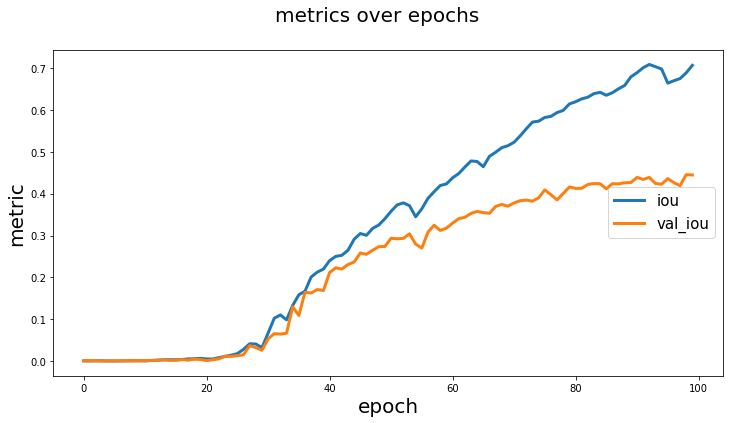

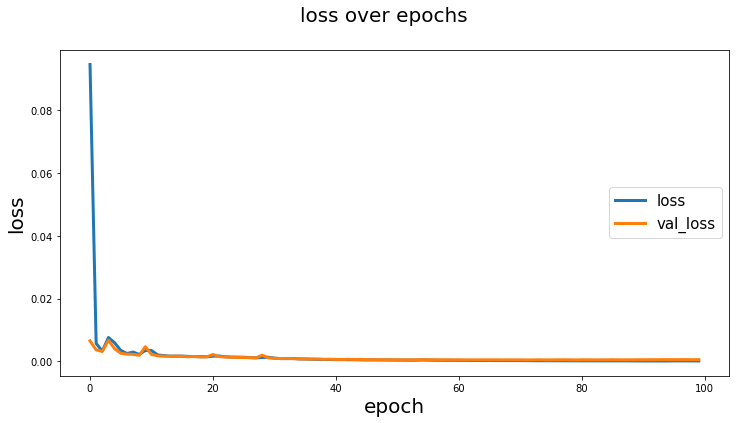

In [19]:
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [20]:
y_pred = model.predict(X_test)

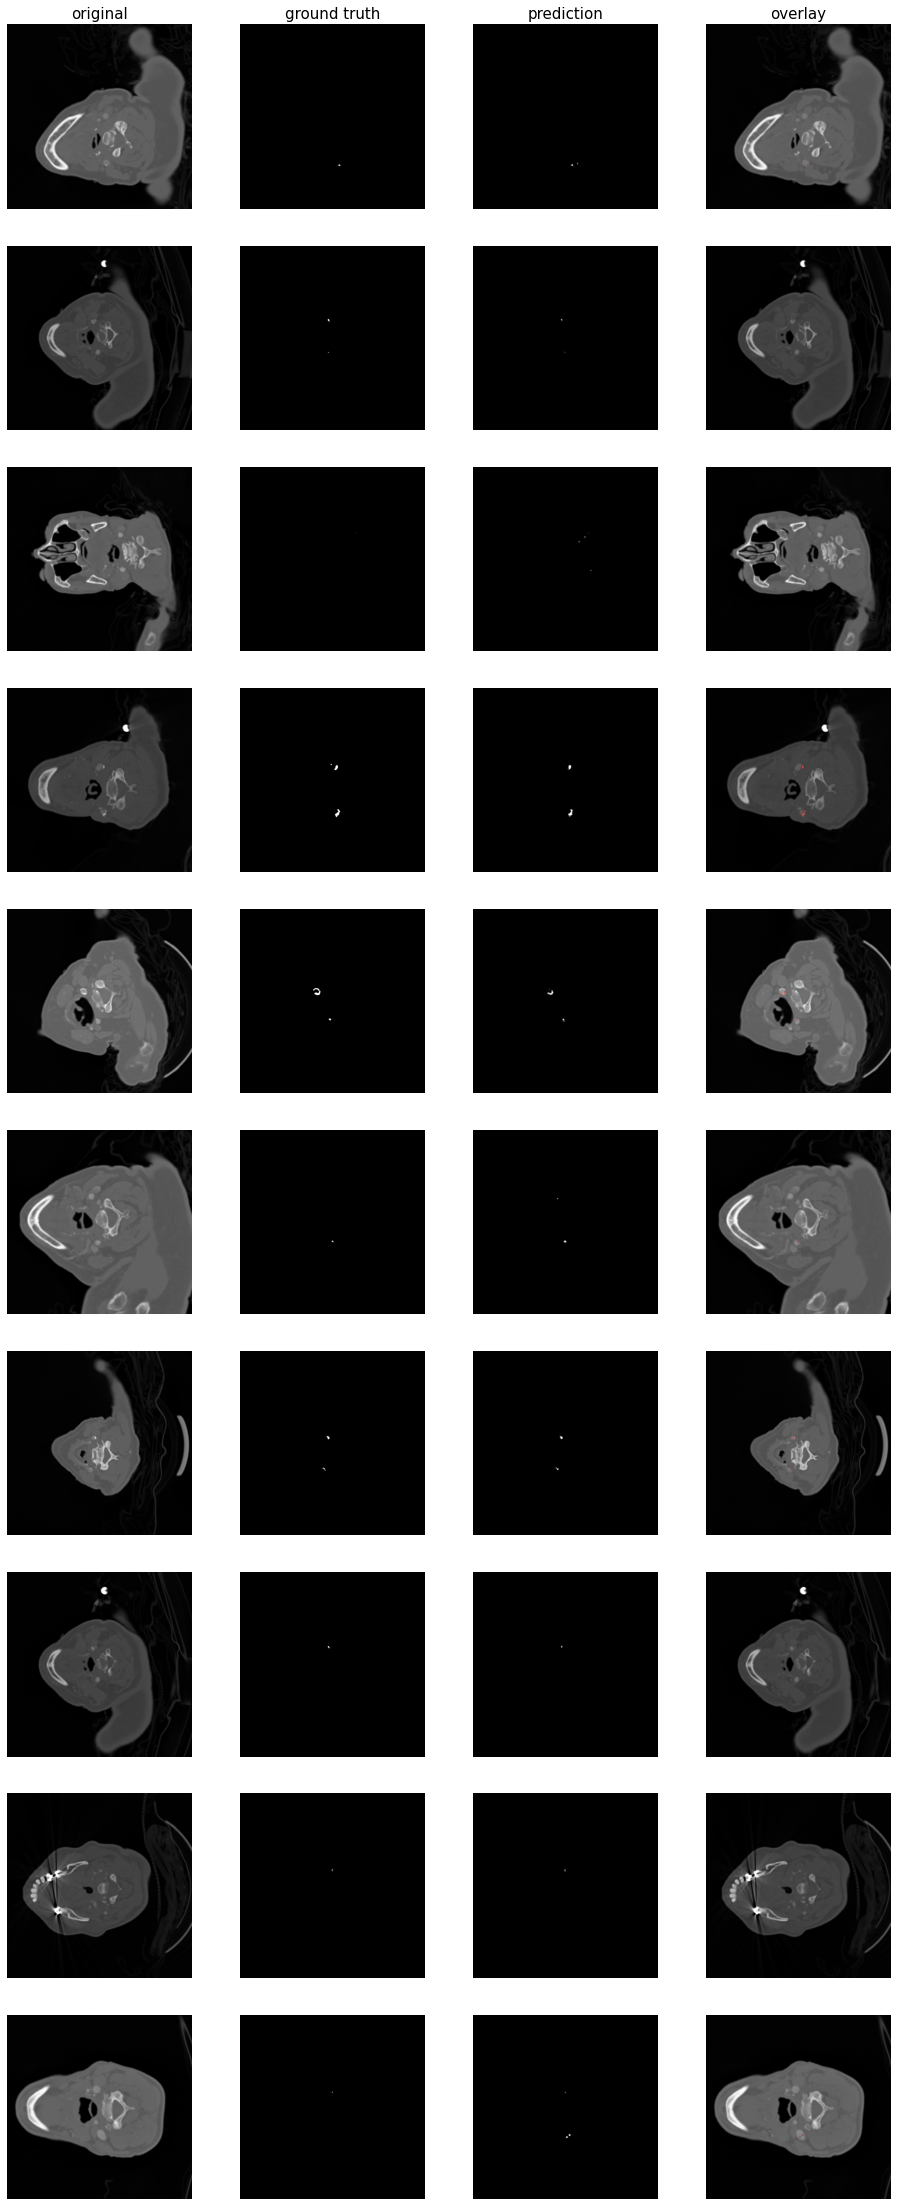

In [21]:
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=10)

In [22]:
loss, iou, iou_thresholded = model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 360ms/step - loss: 6.1562e-04 - accuracy: 0.9999 - dice_coef: 0.6156 - iou: 0.4455 - iou_thresholded: 0.4786


ValueError: too many values to unpack (expected 3)